In [8]:
# !pip install lightning
# !pip install matplotlib
# !pip install torch 
# !pip install tqdm
# !pip install 'numpy<2'
# !pip install -U 'tensorboard'
# !pip install -U 'tensorboardX'
# !pip install pandas
# !pip install scikit-learn

# !python3 -m venv carp_env
# !carp_env/bin/python3 -m pip install ipykernel
# !carp_env/bin/python -m ipykernel install --user --name=carp_env
# !carp_env/bin/python -m pip install -r requirements.txt


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from lightning.pytorch import Trainer, seed_everything, callbacks
from lightning.pytorch.loggers import TensorBoardLogger

from models.sdf_models import LitSdfAE
from models.sdf_models import AE
from datasets.SDF_dataset import SdfDataset, SdfDatasetSurface, collate_fn_surface

dataset_files = ['shape_datasets/ellipse_sdf_dataset_test.csv',
                 'shape_datasets/triangle_sdf_dataset_test.csv', 
                 'shape_datasets/quadrangle_sdf_dataset_test.csv']

dataset = SdfDataset(dataset_files)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Use random_split to create train and test datasets
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, 
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
)

# Create DataLoaders with shuffling
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Enable shuffling for training data
    num_workers=15
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size,
    shuffle=False,  # No need to shuffle test data
    num_workers=15
)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")


surface_files = ['shape_datasets/ellipse_sdf_surface_dataset_test',
                 'shape_datasets/triangle_sdf_surface_dataset_test',
                 'shape_datasets/quadrangle_sdf_surface_dataset_test']

surface_dataset = SdfDatasetSurface(surface_files, cut_value=False)

surface_test_loader = torch.utils.data.DataLoader(
    surface_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=15,
    collate_fn=collate_fn_surface
)

print(f"len(surface_train_loader): {len(surface_test_loader)}")

Training set size: 1200000
Test set size: 300000
len(surface_train_loader): 10


In [2]:
from models.sdf_models import AE_DeepSDF

MAX_EPOCHS = 2
MAX_STEPS = MAX_EPOCHS * len(train_loader)

# Training setup
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(
        name='VAEi', 
        save_dir='./logs', 
        default_hp_metric=False, 
        version='run_test_surface'
    ),
    callbacks=[
        callbacks.ModelCheckpoint(
            monitor='val_total_loss/dataloader_idx_0',
            mode='min',
            save_top_k=1,
            filename='best-model-{epoch:02d}-{val_total_loss:.2f}'
        ),
        callbacks.EarlyStopping(
            monitor='val_total_loss/dataloader_idx_0',
            patience=10,
            mode='min'
        )
    ],
    check_val_every_n_epoch=None,  # Disable validation every epoch
    val_check_interval=4000  # Perform validation every 2000 training steps
)

# Initialize model with L1 regularization
vae_model = AE_DeepSDF(
    input_dim=dataset.feature_dim, 
    latent_dim=3, 
    hidden_dim=128, 
    regularization='l2',   # Use 'l1', 'l2', or None
    reg_weight=1e-3        # Adjust the weight as needed
)

# Initialize the trainer
vae_trainer = LitSdfAE(
    vae_model=vae_model, 
    learning_rate=1e-4, 
    reg_weight=1e-3, 
    regularization='l2',    # Should match the VAE model's regularization
    warmup_steps=1000, 
    max_steps=MAX_STEPS
)

# Train the model
trainer.fit(vae_trainer, train_loader, val_dataloaders=[test_loader, surface_test_loader])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'vae_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae_model'])`.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./logs/VAEi/run_test_s

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0:   5%|▌         | 1017/18750 [00:12<03:31, 83.83it/s, v_num=face, train_total_loss=0.136, train_recon_loss=0.972, train_sdf_loss=0.134, train_reg_loss=1.580]  

/home/kalexu97/Projects/carpenter-sdf-topology-optimizer/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: 100%|██████████| 18750/18750 [06:41<00:00, 46.67it/s, v_num=face, train_total_loss=0.00315, train_recon_loss=1.280, train_sdf_loss=0.00297, train_reg_loss=0.181, val_total_loss/dataloader_idx_0=0.00526, val_recon_loss/dataloader_idx_0=0.852, val_sdf_loss/dataloader_idx_0=0.00511, val_reg_loss/dataloader_idx_0=0.148, val2_total_loss/dataloader_idx_1=0.0439, val2_recon_loss/dataloader_idx_1=8.340, val2_sdf_loss/dataloader_idx_1=0.0424, val2_reg_loss/dataloader_idx_1=1.500, val2_mae/dataloader_idx_1=0.0175, val2_rmse/dataloader_idx_1=0.059, val2_smoothness/dataloader_idx_1=0.0429]   

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 18750/18750 [06:41<00:00, 46.67it/s, v_num=face, train_total_loss=0.00315, train_recon_loss=1.280, train_sdf_loss=0.00297, train_reg_loss=0.181, val_total_loss/dataloader_idx_0=0.00526, val_recon_loss/dataloader_idx_0=0.852, val_sdf_loss/dataloader_idx_0=0.00511, val_reg_loss/dataloader_idx_0=0.148, val2_total_loss/dataloader_idx_1=0.0439, val2_recon_loss/dataloader_idx_1=8.340, val2_sdf_loss/dataloader_idx_1=0.0424, val2_reg_loss/dataloader_idx_1=1.500, val2_mae/dataloader_idx_1=0.0175, val2_rmse/dataloader_idx_1=0.059, val2_smoothness/dataloader_idx_1=0.0429]


In [17]:
# Save model weights
checkpoint_path = 'model_weights/vae_model_weights_test_deepSDF.ckpt'
trainer.save_checkpoint(checkpoint_path)
print(f"Model weights saved to {checkpoint_path}")

# Save just the model weights
model_weights_path = 'model_weights/vae_model_weights_test_deepSDF.pt'
torch.save(vae_model.state_dict(), model_weights_path)
print(f"Model weights saved to {model_weights_path}")

Model weights saved to model_weights/vae_model_weights_test_deepSDF.ckpt
Model weights saved to model_weights/vae_model_weights_test_deepSDF.pt


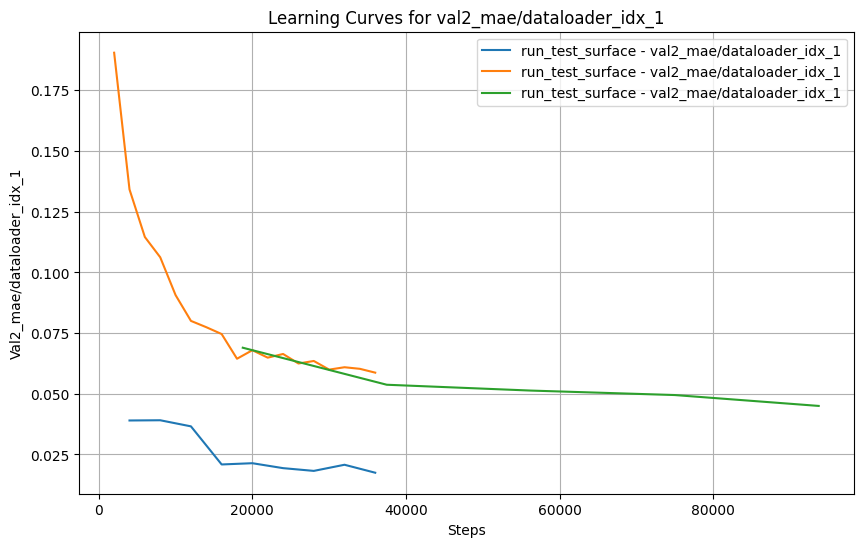

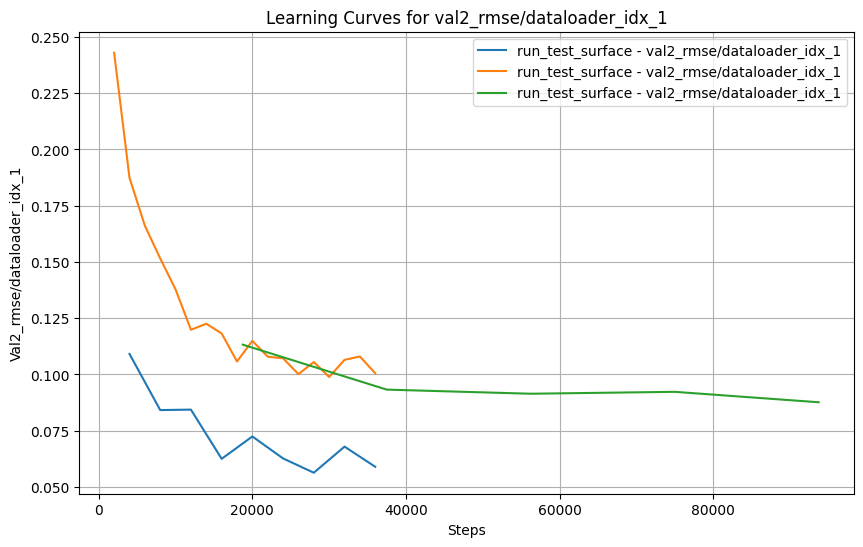

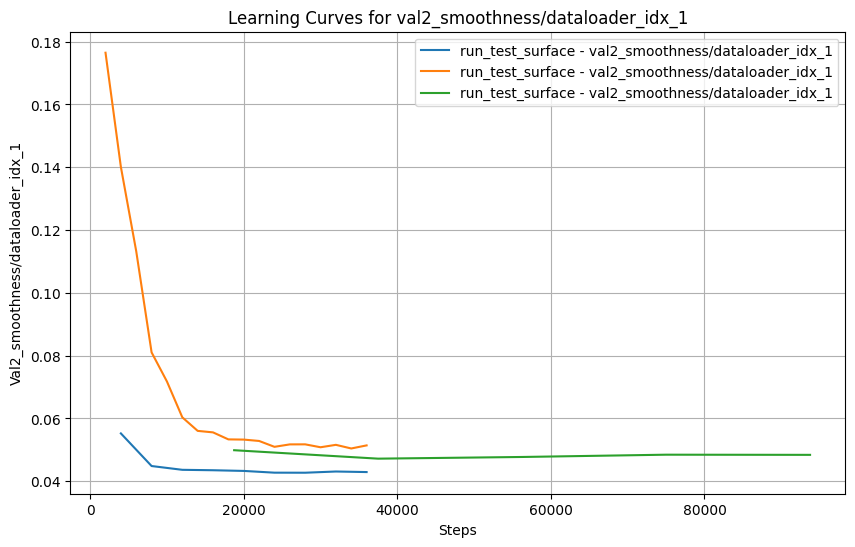

In [3]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_scalars_from_event_file(event_file):
    """Extract scalar data from a TensorBoard event file."""
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()
    
    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        scalars[tag] = event_acc.Scalars(tag)
    
    return scalars

def plot_learning_curves(log_dir, subdirs, metric='loss'):
    """
    Plot learning curves for a specified metric from TensorBoard logs in a directory.
    
    Parameters:
    - log_dir: str, path to the directory containing TensorBoard log subdirectories.
    - metric: str, the metric to plot (e.g., 'loss', 'accuracy').
    """
    plt.figure(figsize=(10, 6))
    
    for subdir in os.listdir(log_dir):
        if subdir in subdirs:
            subdir_path = os.path.join(log_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    if file.startswith('events.out.tfevents'):
                        event_file = os.path.join(subdir_path, file)
                        scalars = extract_scalars_from_event_file(event_file)
                        
                        if metric in scalars:
                            steps = [s.step for s in scalars[metric]]
                            values = [s.value for s in scalars[metric]]
                            plt.plot(steps, values, label=f'{subdir} - {metric}')
    
    plt.title(f'Learning Curves for {metric}')
    plt.xlabel('Steps')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
log_directory = './logs/VAEi'
subdirs = ['run_test_surface']
plot_learning_curves(log_directory, subdirs, metric='val2_mae/dataloader_idx_1')
plot_learning_curves(log_directory, subdirs, metric='val2_rmse/dataloader_idx_1')
plot_learning_curves(log_directory, subdirs, metric='val2_smoothness/dataloader_idx_1')

## Finetuning only the  reconstruct decoder

In [2]:
# Load trainer checkpoint
checkpoint_path = 'model_weights/vae_model_weights_test.ckpt'
vae_model = AE(
    input_dim=dataset.feature_dim, 
    latent_dim=3, 
    hidden_dim=128, 
    regularization='l1',   # Use 'l1', 'l2', or None
    reg_weight=1e-4        # Adjust the weight as needed
)
vae_trainer = LitSdfAE.load_from_checkpoint(checkpoint_path, vae_model=vae_model)
vae_trainer.freeze_decoder_input()


In [4]:
import lightning as L
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR

MAX_EPOCHS = 1
MAX_STEPS = MAX_EPOCHS * len(train_loader)

# Training setup
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='auto',
    devices=1,
    logger=TensorBoardLogger(name='VAEi', save_dir='./logs', default_hp_metric=False),
    callbacks=[
        callbacks.ModelCheckpoint(
            monitor='val_total_loss',
            mode='min',
            save_top_k=1,
            filename='best-model-{epoch:02d}-{val_total_loss:.2f}'
        ),
        callbacks.EarlyStopping(
            monitor='val_total_loss',
            patience=10,
            mode='min'
        )
    ]
)

# Train the model
trainer.fit(vae_trainer, train_loader, val_dataloaders=[test_loader, surface_test_loader])
# trainer.validate(vae_trainer, dataloaders=[test_loader, surface_test_loader])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kalexu97/Projects/Research_2024/top_opt/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'vae_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vae_model'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

/home/kalexu97/Projects/Research_2024/top_opt/lib/python3.12/site-packages/lightning/pytorch/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 15. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃       DataLoader 1        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      val2_recon_loss      │                           │    0.12471601366996765    │
│       val2_reg_loss       │                           │    1.0269496440887451     │
│       val2_sdf_loss       │                           │    0.41664502024650574    │
│      val2_total_loss      │                           │    0.41674771904945374    │
│      val_recon_loss       │     2.813311815261841     │                           │
│       val_reg_loss        │    1.0039680004119873     │                           │
│       val_sdf_loss        │    0.18187497556209564    │                           │
│      val_total_loss       │    0.18197539448738098    │                           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'val_total_loss/dataloader_idx_0': 0.18197539448738098,
  'val_recon_loss/dataloader_idx_0': 2.813311815261841,
  'val_sdf_loss/dataloader_idx_0': 0.18187497556209564,
  'val_reg_loss/dataloader_idx_0': 1.0039680004119873},
 {'val2_total_loss/dataloader_idx_1': 0.41674771904945374,
  'val2_recon_loss/dataloader_idx_1': 0.12471601366996765,
  'val2_sdf_loss/dataloader_idx_1': 0.41664502024650574,
  'val2_reg_loss/dataloader_idx_1': 1.0269496440887451}]

In [4]:
trainer.validate(vae_trainer, dataloaders=[test_loader, surface_test_loader])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 1: 100%|██████████| 10/10 [00:00<00:00, 17.67it/s]     
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val2_mae                                    0.019948702305555344
     val2_recon_loss                                  7.607122421264648
      val2_reg_loss                                  1.2910953760147095
        val2_rmse                                    0.06814579665660858
      val2_sdf_loss                                  0.05470471829175949
     val2_smoothness                                 0.04310668259859085
     val2_total_loss                                 0.05599581450223923
     val_recon_loss         0.7832214832305908
      val_reg_loss          0.12701192498207092
      v

[{'val_total_loss/dataloader_idx_0': 0.007007585372775793,
  'val_recon_loss/dataloader_idx_0': 0.7832214832305908,
  'val_sdf_loss/dataloader_idx_0': 0.006880578584969044,
  'val_reg_loss/dataloader_idx_0': 0.12701192498207092},
 {'val2_total_loss/dataloader_idx_1': 0.05599581450223923,
  'val2_recon_loss/dataloader_idx_1': 7.607122421264648,
  'val2_sdf_loss/dataloader_idx_1': 0.05470471829175949,
  'val2_reg_loss/dataloader_idx_1': 1.2910953760147095,
  'val2_mae/dataloader_idx_1': 0.019948702305555344,
  'val2_rmse/dataloader_idx_1': 0.06814579665660858,
  'val2_smoothness/dataloader_idx_1': 0.04310668259859085}]

# Visualization

Center for Ellipse: ([-0.3834586  -0.22364326  0.01498691])
Covariance for Ellipse: [[ 0.02519936 -0.03459345 -0.00770301]
 [-0.03459345  0.04979151  0.01117647]
 [-0.00770301  0.01117647  0.00284501]]
Center for Triangle: ([0.4165819  0.13748981 0.07504681])
Covariance for Triangle: [[ 0.04413969 -0.03181809  0.01474448]
 [-0.03181809  0.05148893 -0.07260463]
 [ 0.01474448 -0.07260463  0.18851952]]
Center for Quadrangle: ([-0.02429504  0.11189801  0.06477573])
Covariance for Quadrangle: [[ 0.08861719  0.00723653  0.01126354]
 [ 0.00723653  0.0884784  -0.08523035]
 [ 0.01126354 -0.08523035  0.19517688]]
Common Mean: [0.19185032 0.12444469 0.06981124]
Common Covariance: [[ 0.11537973 -0.00908504  0.01409729]
 [-0.00908504  0.07048151 -0.0789452 ]
 [ 0.01409729 -0.0789452   0.19186755]]


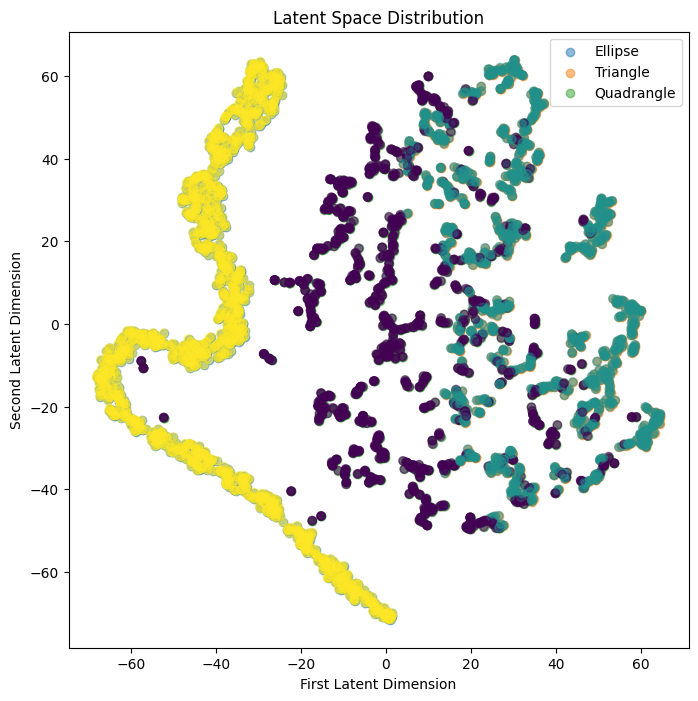

In [9]:
class_names = ['Ellipse', 'Triangle', 'Quadrangle']


def plot_latent_space(model, dataloader, num_samples=4000):
    """Visualize the latent space"""
    model.eval()
    latent_vectors = []
    X = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            _, sdf_out, mu = model(batch[0])
            latent_vectors.append(mu)
            X.append(batch[0])
            sdf.append(sdf_out)
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                break
                
    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    latent_vectors = latent_vectors.cpu().numpy()

    # Use t-SNE for dimensionality reduction
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    
    # Concatenate and convert class labels
    class_labels = torch.cat(class_labels, dim=0)[:num_samples].cpu().numpy()
    class_labels = [class_names[int(label*2)] for label in class_labels]
    
    # Plot the reduced dimensions with colors based on class labels
    plt.figure(figsize=(8,8))
    # Convert class labels to numeric values for coloring
    unique_labels = list(set(class_labels))
    label_to_num = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = [label_to_num[label] for label in class_labels]

    # print(numeric_labels)
    # print(unique_labels)
    for i, label in enumerate(class_names):
        class_bids = [x == label for x in class_labels]
        # Get points for this class
        class_points = latent_2d[class_bids]
        class_latent_vectors = latent_vectors[class_bids]
        # Calculate Gaussian parameters for this class
        class_mean = np.mean(class_latent_vectors, axis=0)
        class_cov = np.cov(class_latent_vectors.T)
        # Calculate and print center
        center = np.mean(class_latent_vectors, axis=0)
        print(f"Center for {label}: ({center})")
        print(f"Covariance for {label}: {class_cov}")
        # Plot points
        plt.scatter(class_points[:, 0], class_points[:, 1], label=label, alpha=0.5)

    # Find common mean and covariance for triangles and quadrangles
    triangle_indices = [i for i, label in enumerate(class_labels) if label == 'Triangle']
    quadrangle_indices = [i for i, label in enumerate(class_labels) if label == 'Quadrangle']
    
    triangle_vectors = latent_vectors[triangle_indices]
    quadrangle_vectors = latent_vectors[quadrangle_indices]
    
    combined_vectors = np.vstack((triangle_vectors, quadrangle_vectors))
    
    common_mean = np.mean(combined_vectors, axis=0)
    common_cov = np.cov(combined_vectors.T)
    
    print(f"Common Mean: {common_mean}")
    print(f"Common Covariance: {common_cov}")

    # print(class_labels == 'Ellipse')
    plt.scatter(latent_2d[:,0], latent_2d[:,1], c=numeric_labels, alpha=0.5)

    # print(*scatter.legend_elements())
    plt.title('Latent Space Distribution')
    plt.xlabel('First Latent Dimension')
    plt.ylabel('Second Latent Dimension')
    # plt.legend(*scatter.legend_elements(), labels=unique_labels, title="Classes")
    plt.legend()
    plt.show()

plot_latent_space(vae_model, test_loader)

<Figure size 1500x500 with 0 Axes>

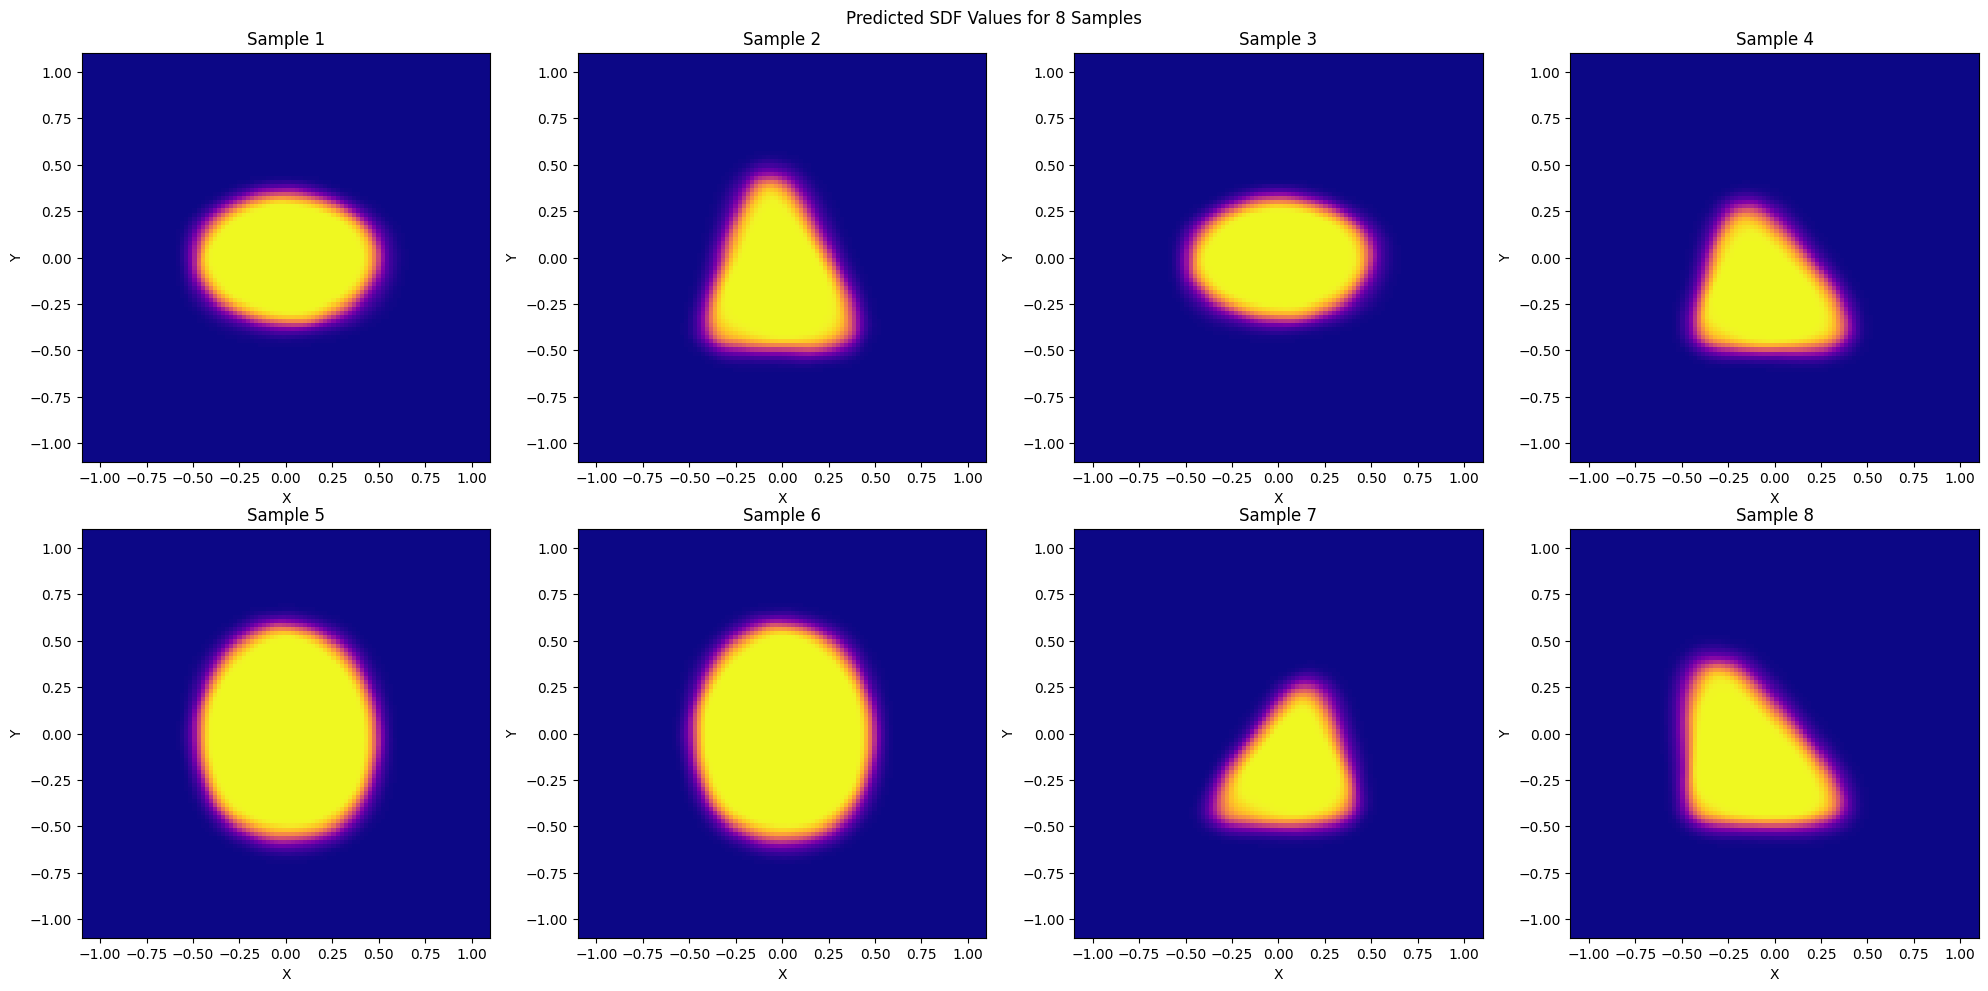

In [10]:
def plot_predicted_sdf(model, test_loader, num_samples=5):
    """Plot predicted SDF values for sample inputs"""
    model.eval()
    plt.figure(figsize=(15, 5))
    
    with torch.no_grad():
        # Get sample batch
        batch = next(iter(test_loader))
        inputs = batch[0][:8]  # Take first 8 samples

        _, _, z = model(inputs)

        x = np.linspace(-1.1, 1.1, 100)
        y = np.linspace(-1.1, 1.1, 100)
        X, Y = np.meshgrid(x, y)
        grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

        fig, axs = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('Predicted SDF Values for 8 Samples')

        for i in range(8):
            row = i // 4
            col = i % 4

            sdf_pred = model.sdf(z[i], grid_points)

            # Reshape predictions
            sdf_grid = sdf_pred.reshape(X.shape)

            # Create scatter plot
            im = axs[row, col].imshow(sdf_grid.numpy(),
                                     extent=[-1.1, 1.1, -1.1, 1.1],
                                     cmap='plasma',
                                     origin='lower')
            axs[row, col].set_aspect('equal')
            axs[row, col].set_title(f'Sample {i+1}')
            axs[row, col].set_xlabel('X')
            axs[row, col].set_ylabel('Y')

        # Add colorbar
        # fig.colorbar(scatter, ax=axs.ravel().tolist(), label='Predicted SDF')

    plt.tight_layout()
    plt.show()

plot_predicted_sdf(vae_model, test_loader)

torch.Size([336, 3])
torch.Size([351, 3])
torch.Size([337, 3])


/tmp/ipykernel_55734/465322034.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z1 = torch.tensor(z1, dtype=torch.float32)
/tmp/ipykernel_55734/465322034.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z2 = torch.tensor(z2, dtype=torch.float32)
/tmp/ipykernel_55734/465322034.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z3 = torch.tensor(z3, dtype=torch.float32)
/tmp/ipykernel_55734/465322034.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight

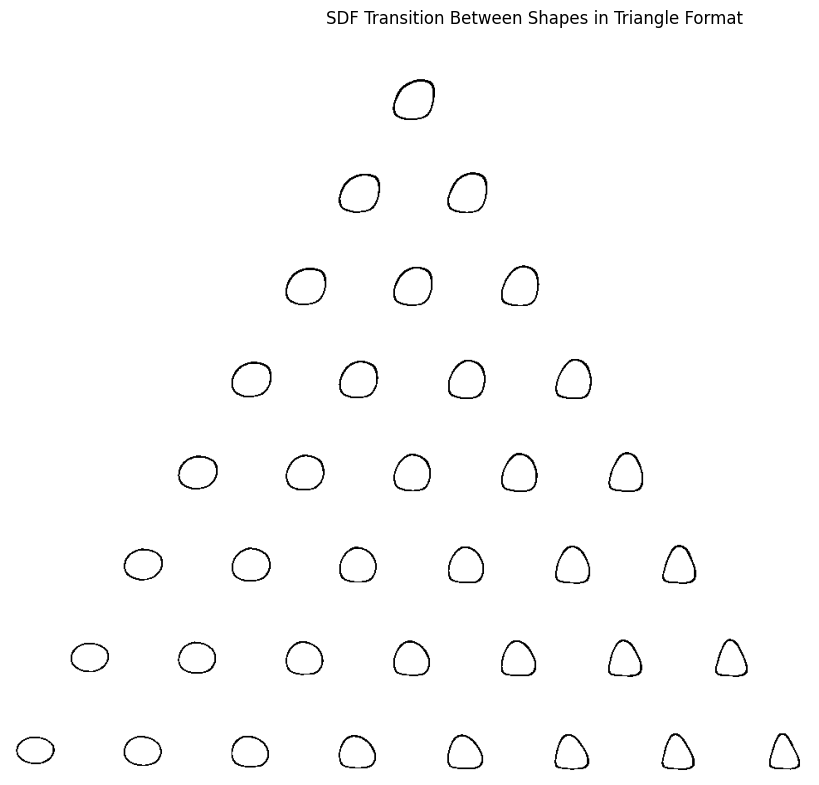

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_curve(grid_points, sdf_pred, ax):

    curve_mask = torch.logical_and(sdf_pred[:, 0] > 0.3, sdf_pred[:, 0] < 0.7)
    curve_mask_reshaped = curve_mask.reshape(100, 100)[20:80, 20:80]
    # curve_points = grid_points[curve_mask]
    # print(curve_points.shape)
    # ax.scatter(curve_points.numpy()[:, 0], curve_points.numpy()[:, 1], c='r', linewidth=2)
    ax.imshow(curve_mask_reshaped, cmap='gray_r', origin='lower')
    return ax

def plot_sdf_transition(model, z_start, z_end, num_steps=10):
    """
    Plots the transition of SDF maps between two latent vectors.
    
    Parameters:
    - model: The VAE model
    - z_start: The starting latent vector
    - z_end: The ending latent vector
    - num_steps: Number of steps in the transition
    """
    z_start = torch.tensor(z_start, dtype=torch.float32)
    z_end = torch.tensor(z_end, dtype=torch.float32)
    
    # Generate intermediate latent vectors
    z_steps = [z_start + (z_end - z_start) * i / (num_steps - 1) for i in range(num_steps)]
    
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, axs = plt.subplots(1, num_steps, figsize=(20, 5))
    fig.suptitle('SDF Transition Between Shapes')
    
    with torch.no_grad():
        for i, z in enumerate(z_steps):
            sdf_pred = model.sdf(z, grid_points)
            sdf_grid = sdf_pred.reshape(X.shape)
            
            # im = axs[i].imshow(sdf_grid.numpy(),
            #                 extent=[-1.1, 1.1, -1.1, 1.1],
            #                 cmap='plasma',
            #                 origin='lower')
            plot_curve(grid_points, sdf_pred, axs[i])
            axs[i].set_aspect('equal')
            axs[i].set_frame_on(False)
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            # axs[i].set_title(f'Step {i+1}')
            # axs[i].set_xlabel('X')
            # axs[i].set_ylabel('Y')
        
    plt.tight_layout()
    plt.show()

def plot_sdf_transition_triangle(model, z1, z2, z3, num_steps=10):
    """
    Plots the transition of SDF maps between three latent vectors in a triangular format.
    
    Parameters:
    - model: The VAE model
    - z1: The first latent vector
    - z2: The second latent vector
    - z3: The third latent vector
    - num_steps: Number of steps in the transition
    """
    z1 = torch.tensor(z1, dtype=torch.float32)
    z2 = torch.tensor(z2, dtype=torch.float32)
    z3 = torch.tensor(z3, dtype=torch.float32)
    
    # Generate intermediate latent vectors
    z_steps = []
    for i in range(num_steps):
        for j in range(num_steps - i):
            z = z1 * (i / (num_steps - 1)) + z2 * (j / (num_steps - 1)) + z3 * ((num_steps - 1 - i - j) / (num_steps - 1))
            z_steps.append(z)
    
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.suptitle('SDF Transition Between Shapes in Triangle Format')

    scale = 1.5 / (num_steps - 1)
    
    with torch.no_grad():
        idx = 0
        for i in range(num_steps):
            for j in range(num_steps - i):
                z = z_steps[idx]
                sdf_pred = model.sdf(z, grid_points)
                sdf_grid = sdf_pred.reshape(X.shape)
                
                # Calculate the position for each icon
                x_pos = (i + 0.5 * j) * scale - 0.55
                y_pos = (np.sqrt(3) / 2 * j) * scale - 0.55
                
                # Plot each SDF as an icon at the calculated position
                ax_inset = fig.add_axes([x_pos, y_pos, 0.1, 0.1])
                plot_curve(grid_points, sdf_pred, ax_inset)
                ax_inset.set_aspect('equal')
                ax_inset.set_frame_on(False)
                ax_inset.set_xticks([])
                ax_inset.set_yticks([])
                idx += 1
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()


def plot_sdf_surface(model, z):
    z = torch.tensor(z, dtype=torch.float32)
    x = np.linspace(-1.1, 1.1, 100)
    y = np.linspace(-1.1, 1.1, 100)
    X, Y = np.meshgrid(x, y)
    grid_points = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    # fig.suptitle('SDF Surface')
    
    with torch.no_grad():
        sdf_pred = model.sdf(z, grid_points)
        sdf_grid = sdf_pred.reshape(X.shape)
        
        # im = ax.imshow(sdf_grid.numpy(),
        #                extent=[-1.1, 1.1, -1.1, 1.1],
        #                cmap='plasma',
                    #    origin='lower')
        plot_curve(grid_points, sdf_pred, ax)
        ax.set_aspect('equal')
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title('SDF Surface')
        # ax.set_xlabel('X')
        # ax.set_ylabel('Y')
        
    plt.tight_layout()
    plt.show()

def get_latent_subspaces(model, dataloader, num_samples=1000):
    """Visualize the latent space"""

    ellipsoid_label = torch.tensor(0)
    triangle_label = torch.tensor(0.5)
    quadrangle_label = torch.tensor(1)

    model.eval()
    latent_vectors = []
    X = []
    sdf = []
    sdf_target = []
    class_labels = []
    with torch.no_grad():
        for batch in dataloader:
            _, sdf_out, mu = model(batch[0])
            latent_vectors.append(mu)
            X.append(batch[0])
            sdf.append(sdf_out)
            sdf_target.append(batch[1])
            class_labels.append(batch[0][:, 2])
            if len(latent_vectors) * batch[0].shape[0] >= num_samples:
                break

    class_labels = torch.cat(class_labels)
    latent_vectors = torch.cat(latent_vectors)

    triangle_latent_vectors = latent_vectors[class_labels == triangle_label]
    quadrangle_latent_vectors = latent_vectors[class_labels == quadrangle_label]
    ellipse_latent_vectors = latent_vectors[class_labels == ellipsoid_label]

    return triangle_latent_vectors, quadrangle_latent_vectors, ellipse_latent_vectors

triangle_latent_vectors, quadrangle_latent_vectors, ellipse_latent_vectors = get_latent_subspaces(vae_model, test_loader)

print(triangle_latent_vectors.shape)
print(quadrangle_latent_vectors.shape)
print(ellipse_latent_vectors.shape)

quadrangle_index = 123
triangle_index = 0
ellipse_index = 0

# plot_sdf_surface(vae_model, quadrangle_latent_vectors[quadrangle_index])

# for i in range(250, 300):
#     print(i)
#     plot_sdf_surface(vae_model, quadrangle_latent_vectors[i])

z_triangle = triangle_latent_vectors[triangle_index]
z_quadrangle = quadrangle_latent_vectors[quadrangle_index]
z_ellipse = ellipse_latent_vectors[ellipse_index]

plot_sdf_transition_triangle(vae_model, z_triangle, z_quadrangle, z_ellipse, num_steps=8)

# z_start = quadrangle_latent_vectors[quadrangle_index]
# z_end = triangle_latent_vectors[triangle_index]
# plot_sdf_transition(vae_model, z_start, z_end, num_steps=8)

# z_start = quadrangle_latent_vectors[quadrangle_index]
# z_end = ellipse_latent_vectors[ellipse_index]
# plot_sdf_transition(vae_model, z_start, z_end, num_steps=8)

# z_start = ellipse_latent_vectors[ellipse_index]
# z_end = triangle_latent_vectors[triangle_index]
# plot_sdf_transition(vae_model, z_start, z_end, num_steps=8)

# z_center = torch.cat([triangle_latent_vectors[0], quadrangle_latent_vectors[0], ellipse_latent_vectors[0]]).mean(dim=0)
# print(z_center.shape)
# plot_sdf_transition(vae_model, z_center, triangle_latent_vectors[0], num_steps=8)
